# Linear SVM + Calc Mertics

Для чего этот ноутбук:
1. Построить бейзлайн по модели "здоров/не здоров"
2. Посмотреть на рызные метрики. Выбрать метрики для моделей бинарной классификации.

In [70]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(21)
random_state = 147

DATA_FOLDER = "data/"

## Download Ready Data

In [71]:
df_images = pd.read_csv(DATA_FOLDER + "data_DEC24_SVD_128comp_5000.csv").iloc[:, 1:]

df_images["class"] = np.where(df_images["class"] != 2, 0, 1)

print("1 - is healthy\n0 - not healthy\n")

print(df_images.shape)
df_images.head(4)

1 - is healthy
0 - not healthy

(5000, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-1297,-4191,4968,13525,23092,2697,6673,-6180,-7511,3308,...,-1621,-333,625,-981,208,-1723,-1369,622,1078,1
1,17405,5688,-8329,-8232,2108,6171,822,1740,1672,1781,...,2242,-2151,-298,-1812,71,303,427,-322,866,0
2,-8478,-25664,-19107,-18964,491,-12445,395,2966,719,3463,...,30,-44,-468,290,-119,-984,44,-989,378,0
3,13479,-25028,12294,6340,2088,11904,-1974,2324,-3662,1154,...,-301,1070,-435,37,-506,-1057,-1564,-861,1274,0


## Split Data

In [72]:
X, y = df_images.drop(columns="class"), df_images["class"]

In [73]:
from sklearn.model_selection import train_test_split

test_size=0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

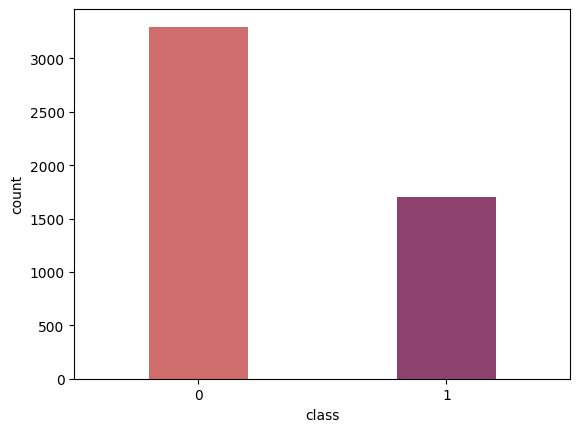

In [74]:
sns.countplot(x=y, hue=y, legend=False, palette='flare', width=0.4);

## Models: Самая первая модель

In [75]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [76]:
scl = StandardScaler().fit(X_train)

X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

In [77]:
model = SVC(kernel = 'linear', random_state=random_state, max_iter=-1, tol=1e-3)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Думаем про метрики для бинарной классификации

Общие соображения:
* метрики от 0 до 1 классные, потомучто их легче интерпретировать
* интегральные метрики классные, так как позволяют оценить модель по разным trashhold-ам одновременно

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

### **Матрица ошибок**

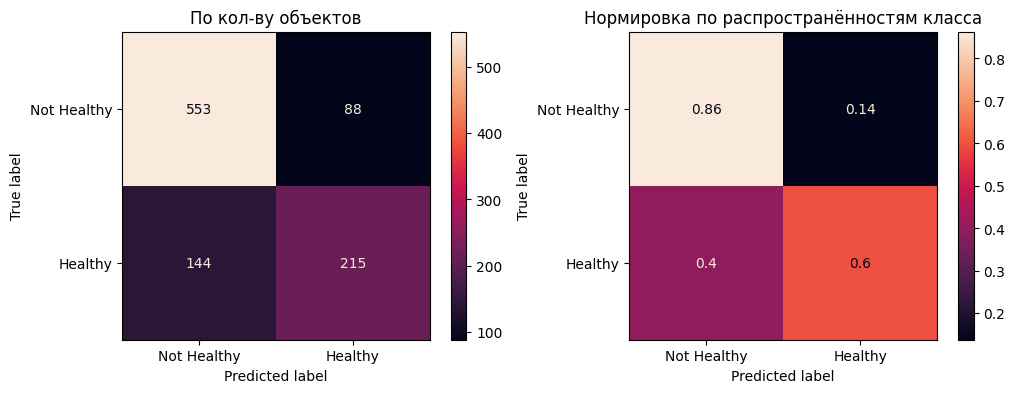

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

labels = ["Not Healthy", "Healthy"]
ax[0].set_title("По кол-ву объектов")
ax[1].set_title("Нормировка по распространённостям класса")

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=labels, cmap="rocket", ax=ax[0])
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=labels, cmap="rocket", normalize="true", ax=ax[1]);

Чем хороша матрица ошибок:
* визуальная, красивая, можно показать в презентации
* лёгко интерпретируется
* видно где модель больше ошибается
    * например, у нас сейчас FN > FP

ConfusionMatrix пригодится, возьмём в пулл "долгих метрик"

### **Accuracy**

In [81]:
print(f"Доля правильных ответов: {np.round(accuracy_score(y_test, y_pred), 8)}")
print(f"Доля правильных ответов (balanced): {np.round(balanced_accuracy_score(y_test, y_pred), 8)}")

Доля правильных ответов: 0.768
Доля правильных ответов (balanced): 0.73080015


* Использовать стандартный accuracy при дисбалансе классов не надёжно.

* При дисбалансе 1:4, константная модель может получить 0.8 accuracy, хотя это плохая модель.

* В нашем случае сбалансированный accuracy ниже.

### **F1-score**

* Можно интерпретировать как гармоническое среднее precision и recall
* Стратегия weighed - считаем f1_score для каждого класса, и домножаем на долю распростанённости этого класса
* Стратегия weighed подходит лучше других статегий, так как имеется дисбаланс классов

In [90]:
f1_harmonic = f1_score(
    y_test, y_pred,
    average='weighted'  # This alters 'macro' to account for label imbalance; it can result in an F-score that is not between precision and recall.
)
s = np.round(np.sum(y_test == 0)/y_test.shape[0], 8)
print(f"f1_score: {f1_harmonic:.8f}")
print(f"Доля распр. класса: {s}")

f1_score: 0.76304232
Доля распр. класса: 0.641


### **Кастомная метрика**

Поскольку наблюдается дизбаланс классов, хочется ввести кастомную метрику "Нормированный выйгрыш"
<br><br>
$$Win_{norm} = \frac{F1 -Prop}{1 - Prop},$$ 

где
* $ Prop $ - доля мажоритарного класса
* $ F1 $ - f1-score

Обозначает величину выигрыша от того что было возможно выиграть.
* Принимает значения от $-\infty$ до $1$. 
* В идеале 1.
* 0 - качесто предсказаний модели такое же, какое у константной модели.
* Если значение отрицательное, то качество модели хуже, чем у константной модели

In [89]:
print(f"Выигрыш: {(f1_harmonic - s):.8f}")
print(f"Выигрыш (нормир.): {(f1_harmonic - s)/(1 - s):.8f}")

Выигрыш: 0.12204232
Выигрыш (нормир.): 0.33995075


## Интегральные метрики

In [93]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

Есть много интегральных метрик. Давайте остановимся на 
* ROC-AUC
* Gini
* RocCurve
* DET curve

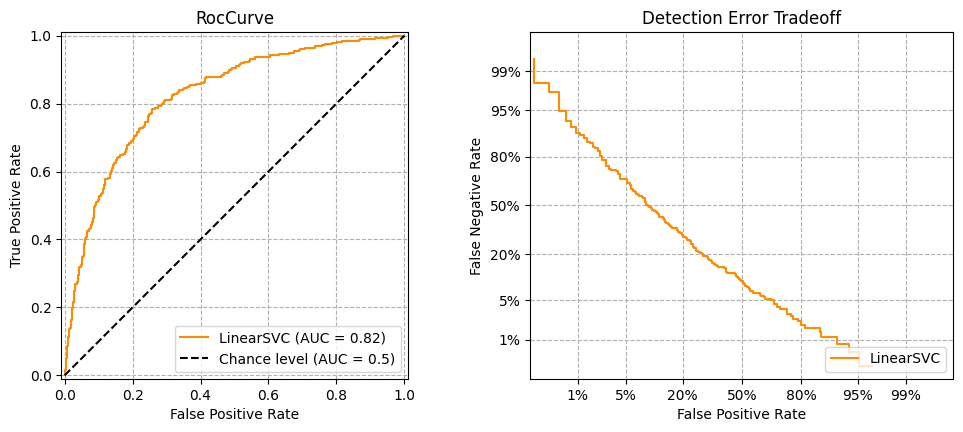

In [108]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(12, 4.5))

display = RocCurveDisplay.from_estimator(model, X_test, y_test, plot_chance_level=True, name="LinearSVC", color="darkorange", ax=ax_roc)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="RocCurve",
)

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

display = DetCurveDisplay.from_estimator(model, X_test, y_test, name="LinearSVC", color="darkorange", ax=ax_det)
_ = display.ax_.set(
    title="Detection Error Tradeoff",
    xlabel="False Positive Rate",
    ylabel="False Negative Rate",
)

In [87]:
roc_auc_metric = roc_auc_score(y_pred, y_test)
gini = 2 * roc_auc_metric - 1

print("roc_auc: ", np.round(roc_auc_metric, 8))
print("gini: ", np.round(gini, 8))

roc_auc:  0.75148562
gini:  0.50297124


Использовать коэффициент Gini предпочтительнее, его немного проще оценить без картинки. Т.к. в нём не учитывается треугольник ниже уровня шансов. Если в дополнение исользовать ROC кривую, то совсем нет разницы что именно использвать.

## Выводы

1. Линейных преобразований и линейных моделей оказалось достаточно чтобы получить f1-score больше, чем долю распространённого класса
2. Выбрали метрики для разных ситуаций:

|Группа метрик|Метрики|Ситуация использования|
|:-|:-|:-|
|"Быстрые"|`f1-score`, `Win-norm (кастомная)`|Eсли нужно оценить модель в моменте при быстрых экспрементах|
|"Вдумчивые"|`confusion matrix`, `ROC-AUC`, `Gini`, `RocCurve`, `DETCurve`|Для более вдумчивого анализа|

В зависимости от задачи (binary or multi), используются соотвествующие модицикации.